# ECMWF Polytope Region of Interest (DEDT Lumi)

The EMCWF Polytope API now supports bespoke geometry definions in queries.

`eodag` supports this feature via de `geom` parameter for the `dedt_lumi` provider.

In [1]:
from eodag import EODataAccessGateway
import json

dag = EODataAccessGateway()

result = dag.search(
    provider="dedt_lumi",
    start="20210101",
    productType="DT_CLIMATE_ADAPTATION",
    geom={'lonmin': 20, 'latmin': 20, 'lonmax': 40, 'latmax': 40},
)

print(json.dumps(result.as_geojson_object(), indent=2, default= str))

/home/rojovelasco/dedl/eodag/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
onda skipped: could not be loaded from user configuration


{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              20.0,
              20.0
            ],
            [
              20.0,
              40.0
            ],
            [
              40.0,
              40.0
            ],
            [
              40.0,
              20.0
            ],
            [
              20.0,
              20.0
            ]
          ]
        ]
      },
      "id": "DT_CLIMATE_ADAPTATION_ORDERABLE_ca8d9c8057b69e23abe6d85ada7838fcfffaf6e8",
      "assets": {},
      "properties": {
        "eodag_product_type": "DT_CLIMATE_ADAPTATION",
        "eodag_provider": "dedt_lumi",
        "eodag_search_intersection": {
          "type": "Polygon",
          "coordinates": [
            [
              [
                20.0,
                40.0
              ],
              [
                40.0,
                40.

The `geom` parameter is translated into a polygon using Polytope's syntax.
All the the `geom` types are supported, `bbox` as shown above, `shapely polygon` and `WKT`.

First we need to download the requested file.

In [2]:
files = dag.download_all(result)

DT_CLIMATE_ADAPTATION_ORDERABLE_ca8d9c8057b69e23abe6d85ada7838fcfffaf6e8: 0.00B [00:01, ?B/s]


2f42ca4e-8cf0-42d6-a239-f563566a7787: 0.00B [00:00, ?B/s]
2f42ca4e-8cf0-42d6-a239-f563566a7787: 0.00B [00:00, ?B/s]
2f42ca4e-8cf0-42d6-a239-f563566a7787: 0.00B [00:00, ?B/s]
2f42ca4e-8cf0-42d6-a239-f563566a7787: 0.00B [00:00, ?B/s]
2f42ca4e-8cf0-42d6-a239-f563566a7787: 0.00B [00:00, ?B/s]
2f42ca4e-8cf0-42d6-a239-f563566a7787: 0.00B [00:00, ?B/s]
2f42ca4e-8cf0-42d6-a239-f563566a7787: 100%|██████████| 9.66M/9.66M [00:00<00:00, 18.0MB/s]
Downloaded products: 100%|██████████| 1/1 [01:28<00:00, 88.21s/product]


When requesting a RoI, ECMWF Polytope will generate a `covjson` file.

To plot it, we are going to load it into an `xarray` dataset.

<xarray.Dataset> Size: 6MB
Dimensions:    (datetimes: 1, number: 1, steps: 1, points: 105105)
Coordinates:
  * datetimes  (datetimes) <U20 80B '2021-01-01 00:00:00Z'
  * number     (number) int64 8B 0
  * steps      (steps) int64 8B 0
  * points     (points) int64 841kB 0 1 2 3 4 ... 105101 105102 105103 105104
    latitude   (points) float64 841kB 20.03 20.03 20.03 ... 39.98 39.98 39.98
    longitude  (points) float64 841kB 20.08 20.17 20.26 ... 39.81 39.9 39.99
    levelist   (points) float64 841kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    sp         (datetimes, number, steps, points) float64 841kB 9.51e+04 ... ...
    10u        (datetimes, number, steps, points) float64 841kB -0.8547 ... -...
    10v        (datetimes, number, steps, points) float64 841kB -4.622 ... -0...
Attributes: (12/15)
    activity:     scenariomip
    class:        d1
    dataset:      climate-dt
    experiment:   ssp3-7.0
    expver:       0001
    generation:   1
    ...           ...
   

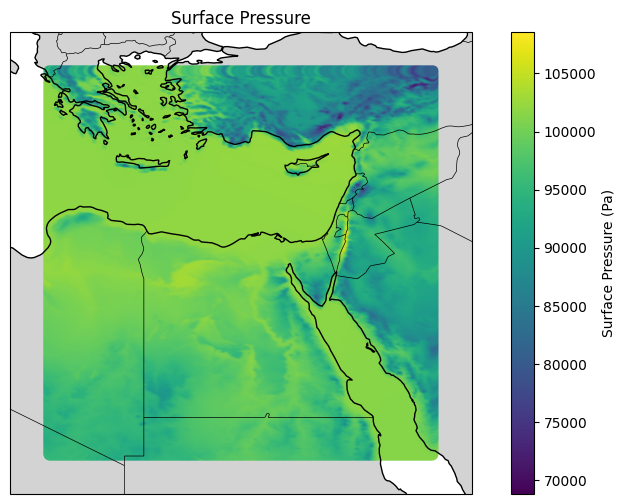

In [3]:
import os
import json
from covjsonkit.api import Covjsonkit

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

for f in files:
    path = os.path.join(f,os.listdir(f)[0])

    with open(path) as f:
        covjson = json.load(f)
    
    # Load CovJson using covjsonkit into an xarray
    decoder = Covjsonkit().decode(covjson)
    ds = decoder.to_xarray()

    print(ds)
        
    # Extracting sp variable from dataset
    # Data in the original covjson is organize in points rather than lat/lon variables
    # so we plot as scatter.

    sp = ds['sp'].isel(datetimes=0, number=0, steps=0).values
    lats = ds['latitude'].values
    lons = ds['longitude'].values

    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    sc = ax.scatter(lons, lats, c=sp, s=40, cmap='viridis',
                    transform=ccrs.PlateCarree())
    
    plt.colorbar(sc, orientation='vertical', label='Surface Pressure (Pa)')

    margin = 2
    ax.set_extent([
        lons.min()-margin, lons.max()+margin,
        lats.min()-margin, lats.max()+margin
    ], crs=ccrs.PlateCarree())

    plt.title("Surface Pressure")
    plt.show()


